In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')          # suppress deprecation & future warnings
import pandas as pd                        # data manipulation
import numpy as np
import matplotlib.pyplot as plt            # plotting   
import seaborn as sns                      # higher-level plots
import os
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import FileLink, FileLinks, HTML, display

In [2]:
file_path = 'HBAED Student Analysis.xlsx'

In [3]:
# Load the uploaded file
xls = pd.ExcelFile(file_path)

In [4]:
# Load sheets
students_df = xls.parse('Students')
attendance_df = xls.parse('Attendance')
behaviour_df = xls.parse('Behaviour')
date_df = xls.parse('Date Table')

In [5]:
# Merge attendance with student and date data
attendance = attendance_df.merge(students_df[['StudentID', 'Gender', 'YearGroup']], on='StudentID', how='left')
attendance = attendance.merge(date_df[['Date', 'School Week']], left_on='CalendarStartDate', right_on='Date', how='left')

# Merge behaviour with student and date data
behaviour = behaviour_df.merge(students_df[['StudentID', 'Gender', 'YearGroup']], on='StudentID', how='left')
behaviour = behaviour.merge(date_df[['Date', 'School Week']], left_on='EventDate', right_on='Date', how='left')

In [6]:
# Attendance % based on 'Present' in MarkMeaningName
attendance_summary = attendance.groupby('StudentID').agg(
    total_sessions=('MarkMeaningName', 'count'),
    present_sessions=('MarkMeaningName', lambda x: (x == 'P').sum())
).reset_index()
attendance_summary['attendance_pct'] = (attendance_summary['present_sessions'] / attendance_summary['total_sessions']) * 100

In [7]:
# Group and sum Adjustments for Positive behaviour
positive_points = behaviour_df[behaviour_df['CategoryName'] == 'Positive'] \
    .groupby('StudentID')['Adjustment'].sum().reset_index()
positive_points.rename(columns={'Adjustment': 'positive_points'}, inplace=True)

# Group and sum Adjustments for Negative behaviour
negative_points = behaviour_df[behaviour_df['CategoryName'] == 'Negative'] \
    .groupby('StudentID')['Adjustment'].sum().reset_index()
negative_points.rename(columns={'Adjustment': 'negative_points'}, inplace=True)

# Merge both summaries and fill any missing values with 0
behaviour_summary = pd.merge(positive_points, negative_points, on='StudentID', how='outer').fillna(0)

# Calculate net points
behaviour_summary['net_points'] = behaviour_summary['positive_points'] + behaviour_summary['negative_points']

In [8]:
dashboard = students_df.merge(attendance_summary, on='StudentID', how='left')
dashboard = dashboard.merge(behaviour_summary, on='StudentID', how='left')
dashboard.head()

,StudentID,AdmissionNumber,First Name,Last Name,DateOfBirth,Gender,TutorGroup,YearGroup,Ethnicity,AddressLine1,AddressLine2,total_sessions,present_sessions,attendance_pct,positive_points,negative_points,net_points
0,9091,EXA0010,Firstname 10,Lastname 10,2009-04-17,M,11-RRU,11,WOTH,Address line 1 Student 1,Address Line 2 Student 1,136.0,102.0,75.000000,5.0,0.0,5.0
1,9106,EXA0011,Firstname 11,Lastname 11,2009-04-08,M,11-RRU,11,BAFR,Address line 1 Student 2,Address Line 2 Student 2,136.0,124.0,91.176471,56.0,-131.0,-75.0
2,9108,EXA0012,Firstname 12,Lastname 12,2009-02-11,M,11-MATCH,11,WBRI,Address line 1 Student 3,Address Line 2 Student 3,136.0,120.0,88.235294,52.0,0.0,52.0
3,9121,EXA0013,Firstname 13,Lastname 13,2009-08-02,M,11-RRU,11,BAFR,Address line 1 Student 4,Address Line 2 Student 4,136.0,106.0,77.941176,11.0,-23.0,-12.0
4,9123,EXA0014,Firstname 14,Lastname 14,2009-08-22,M,11-MAT2,11,BOTH,Address line 1 Student 5,Address Line 2 Student 5,136.0,128.0,94.117647,40.0,0.0,40.0


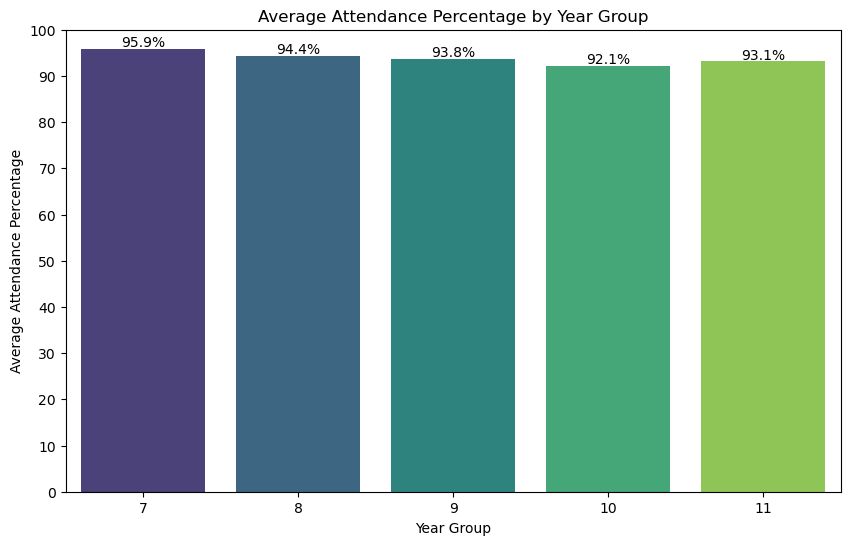

In [9]:
# Calculate average attendance percentage by year group
average_attendance_by_year = dashboard.groupby('YearGroup')['attendance_pct'].mean().reset_index()

# Create the chart
plt.figure(figsize=(10, 6))
sns.barplot(x='YearGroup', y='attendance_pct', data=average_attendance_by_year, palette='viridis')
plt.xlabel('Year Group')
plt.ylabel('Average Attendance Percentage')
plt.title('Average Attendance Percentage by Year Group')
plt.ylim(0, 100)
plt.yticks(range(0,101,10)) 

for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height + 0.5, f'{height:.1f}%', ha='center')

plt.show()

    YearGroup  School Week  Average Attendance Percentage
0         7.0            1                      98.766447
1         7.0            2                      97.932817
2         7.0            3                      98.141026
3         7.0            4                      96.858974
4         7.0            5                      95.769231
..        ...          ...                            ...
65       11.0           12                      91.523179
66       11.0           13                      90.066225
67       11.0           14                      90.000000
68       11.0           15                      93.973510
69       11.0           16                      93.377483

[70 rows x 3 columns]


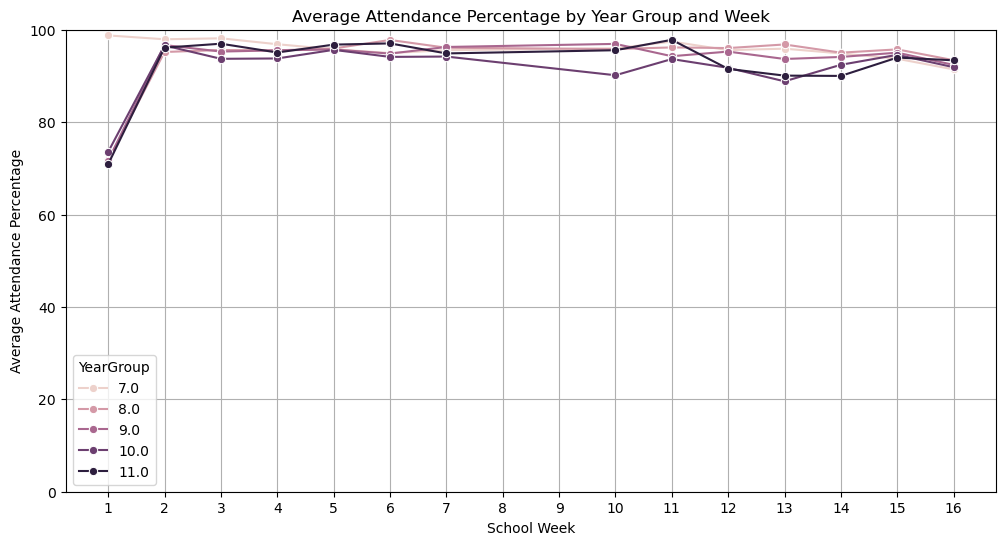

In [11]:
# Calculate average attendance percentage by year group and week
average_attendance_by_year_week = attendance.groupby(['YearGroup', 'School Week'])['MarkMeaningName'].agg(lambda x: (x == 'P').sum() / len(x) * 100).reset_index()
average_attendance_by_year_week.rename(columns={'MarkMeaningName': 'Average Attendance Percentage'}, inplace=True)

# Display the result
print(average_attendance_by_year_week)

# Create the chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='School Week', y='Average Attendance Percentage', hue='YearGroup', data=average_attendance_by_year_week, marker='o')
plt.xlabel('School Week')
plt.ylabel('Average Attendance Percentage')
plt.title('Average Attendance Percentage by Year Group and Week')
plt.ylim(0, 100)
plt.xticks(range(min(average_attendance_by_year_week['School Week']), max(average_attendance_by_year_week['School Week']) + 1))
plt.grid(True)
plt.show()

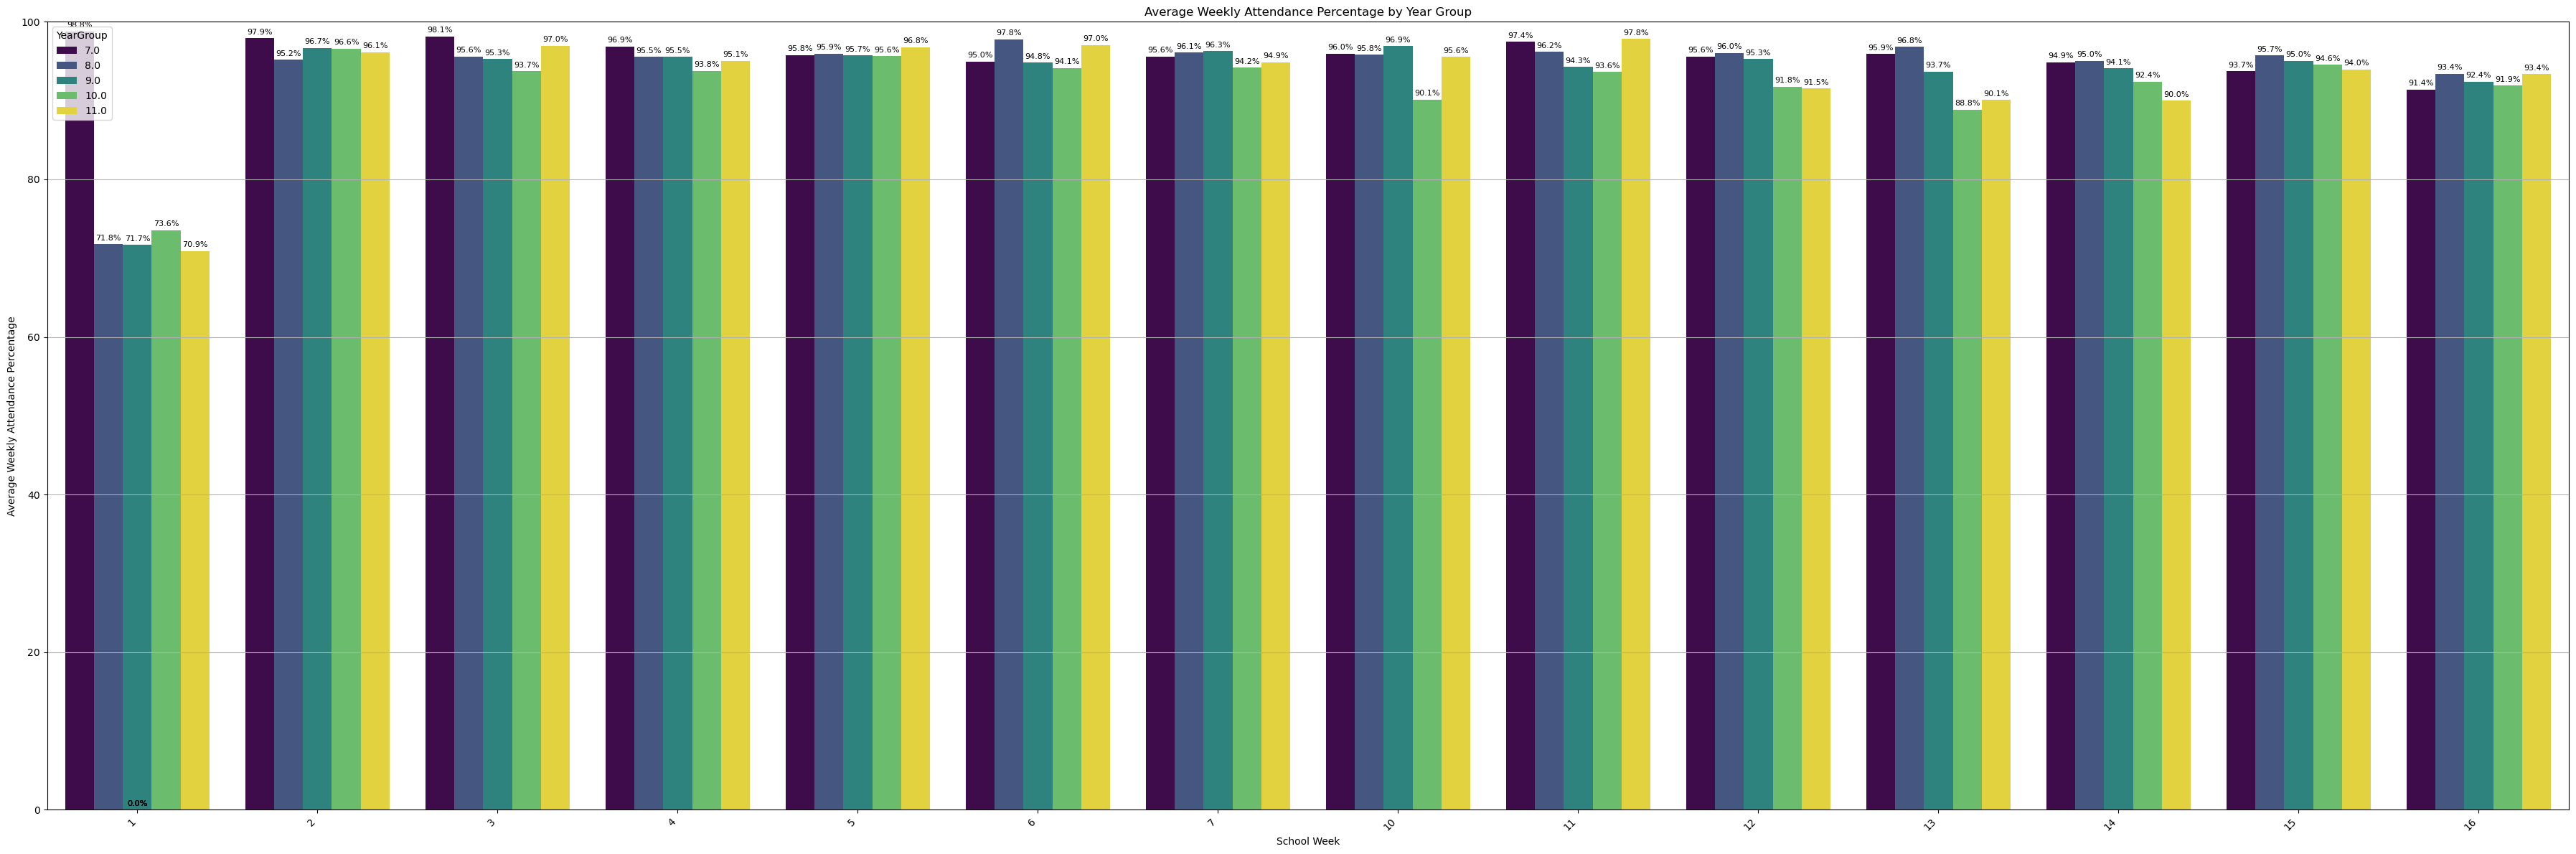

In [12]:
# Bar chart to show weekly attendance percentage
plt.figure(figsize=(36, 12))
sns.barplot(x='School Week', y='Average Attendance Percentage', hue='YearGroup', data=average_attendance_by_year_week, palette='viridis')
plt.xlabel('School Week')
plt.ylabel('Average Weekly Attendance Percentage')
plt.title('Average Weekly Attendance Percentage by Year Group')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height + 0.5, f'{height:.1f}%', ha='center', fontsize=8)

plt.tight_layout() 
plt.show()

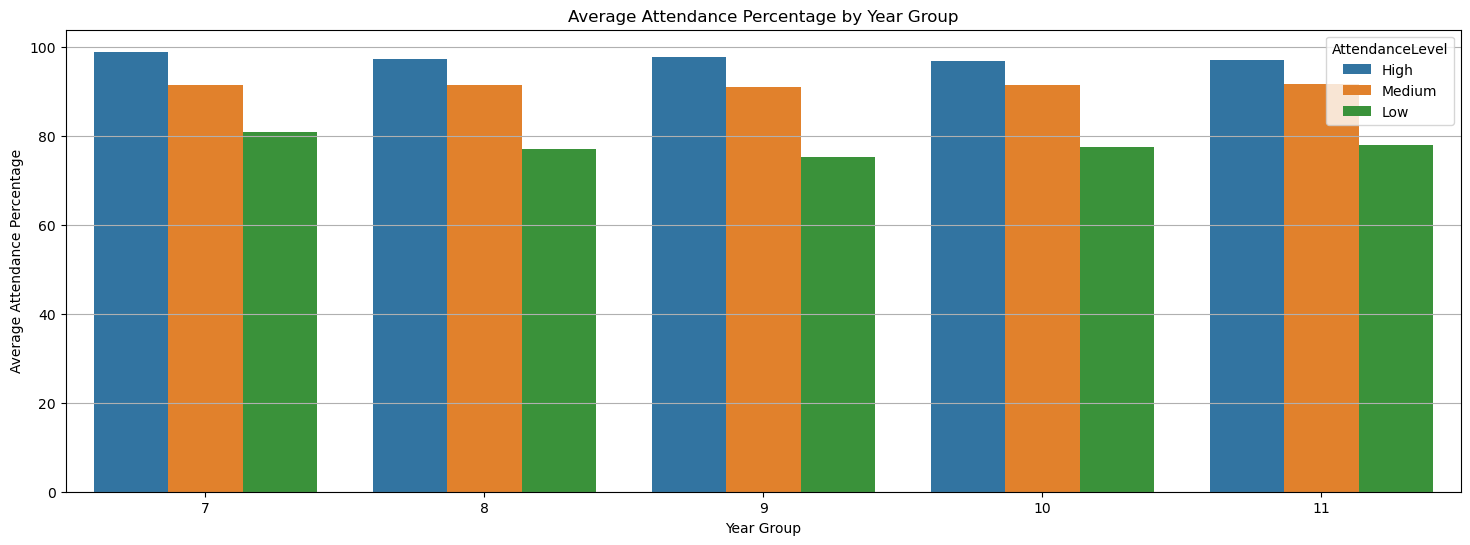

In [13]:
# Calculate data levels for attendance

def attendance_level(percentage):
    if percentage >= 95:
        return 'High'
    elif percentage >= 85:
        return 'Medium'
    else:
        return 'Low'

dashboard['AttendanceLevel'] = dashboard['attendance_pct'].apply(attendance_level)

plt.figure(figsize=(18, 6))
sns.barplot(x='YearGroup', y='attendance_pct', hue='AttendanceLevel', data=dashboard, ci=None)  # ci=None removes error bars
plt.title('Average Attendance Percentage by Year Group')
plt.ylabel('Average Attendance Percentage')
plt.xlabel('Year Group')
plt.grid(True, axis='y')
plt.show()

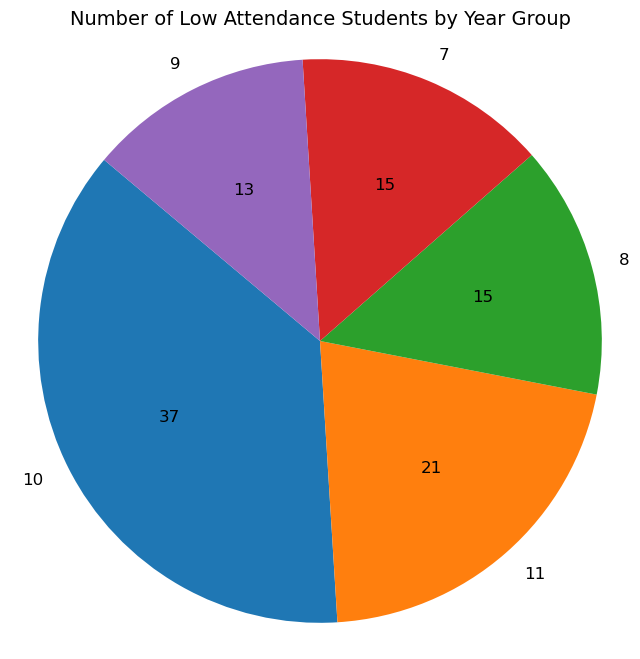

In [14]:
# Filter for low attendance students
low_attendance_students = dashboard[dashboard['AttendanceLevel'] == 'Low']

# Count the number of low attendance students by year group
low_attendance_counts = low_attendance_students['YearGroup'].value_counts().reset_index()
low_attendance_counts.columns = ['YearGroup', 'Count']

plt.figure(figsize=(8, 8))
plt.pie(low_attendance_counts['Count'], labels=low_attendance_counts['YearGroup'], autopct='%1.0f', startangle=140, textprops={'fontsize': 12})
plt.title('Number of Low Attendance Students by Year Group', fontsize=14)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [15]:
# Filter students with attendance percentage less than 85%
low_attendance_students = dashboard[dashboard['attendance_pct'] < 85]

# Sort by attendance percentage in ascending order
low_attendance_students = low_attendance_students.sort_values(by='attendance_pct')

# Format the attendance percentage to two decimal places
low_attendance_students['attendance_pct'] = low_attendance_students['attendance_pct'].round(2)

print(low_attendance_students[['StudentID', 'First Name', 'Last Name', 'attendance_pct']])

     StudentID     First Name     Last Name  attendance_pct
174      10195  Firstname 210  Lastname 210           52.99
412      11657  Firstname 500  Lastname 500           53.68
296      10488  Firstname 353  Lastname 353           61.19
119      10192  Firstname 154  Lastname 154           64.71
376       9196  Firstname 464  Lastname 464           68.38
453      14201  Firstname 544  Lastname 544           69.12
338      13321  Firstname 396  Lastname 396           69.85
691      13261  Firstname 847  Lastname 847           71.32
661      13281  Firstname 812  Lastname 812           72.06
39       11629   Firstname 51   Lastname 51           72.06
483      10169  Firstname 618  Lastname 618           73.53
266       9109  Firstname 323  Lastname 323           73.53
697      13693  Firstname 854  Lastname 854           75.00
255      14175  Firstname 298  Lastname 298           75.00
0         9091   Firstname 10   Lastname 10           75.00
479      10119  Firstname 614  Lastname 

In [16]:
# Total Behaviour Events By Year Group
behaviour_events_by_year = behaviour.groupby(behaviour['StudentID'].map(students_df.set_index('StudentID')['YearGroup']))['EventID'].count().reset_index()
behaviour_events_by_year.rename(columns={behaviour_events_by_year.columns[0]: 'YearGroup'}, inplace=True)
behaviour_events_by_year.rename(columns={'EventID': 'Total Behaviour Events'}, inplace=True)
behaviour_events_by_year['YearGroup'] = behaviour_events_by_year['YearGroup'].astype('Int64')

print(behaviour_events_by_year)

   YearGroup  Total Behaviour Events
0          7                   21409
1          8                   17810
2          9                   18203
3         10                   10433
4         11                    5405


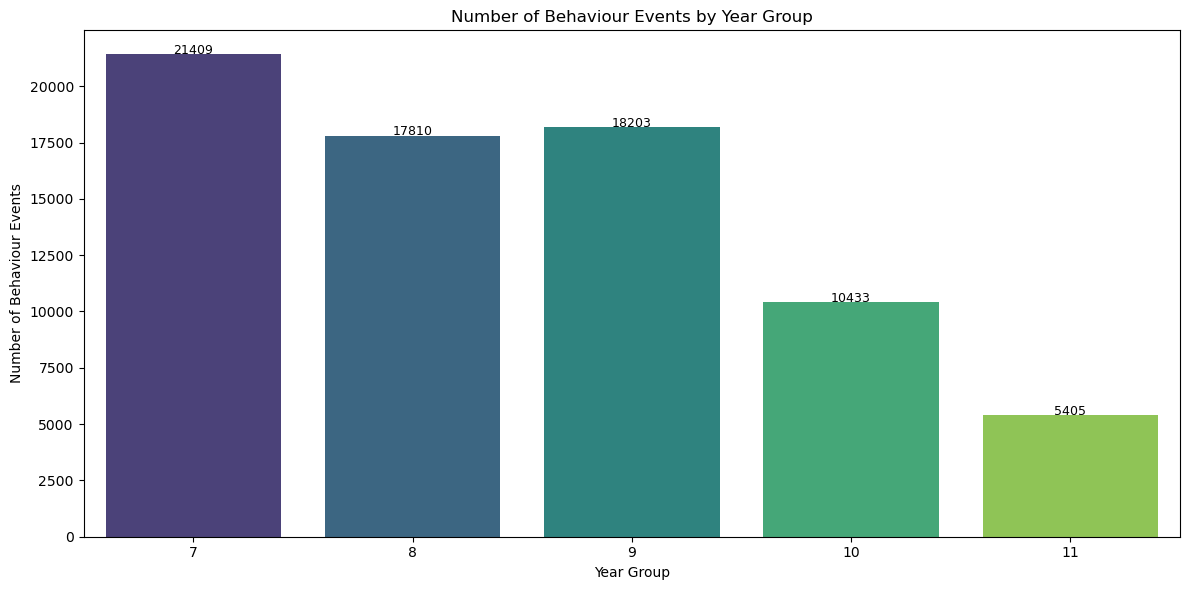

In [17]:
# Bar chart for behaviour events by year group
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='YearGroup', y='Total Behaviour Events', data=behaviour_events_by_year, palette='viridis')
plt.xlabel('Year Group')
plt.ylabel('Number of Behaviour Events')
plt.title('Number of Behaviour Events by Year Group')
plt.xticks(rotation=0)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5,  # Adjust the vertical offset for better placement
            f'{int(height)}',
            ha='center', fontsize=9)

plt.tight_layout()
plt.show()


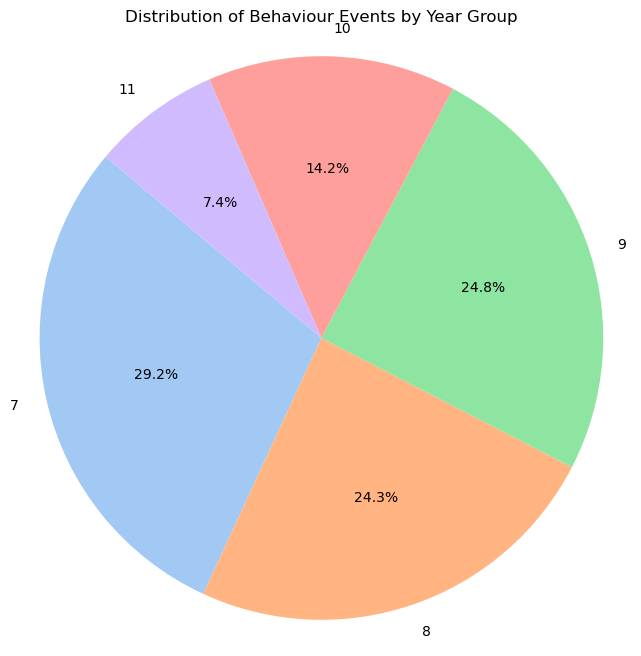

In [18]:
# Pie chart for behaviour events by year group
plt.figure(figsize=(8, 8))
plt.pie(behaviour_events_by_year['Total Behaviour Events'], labels=behaviour_events_by_year['YearGroup'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Behaviour Events by Year Group')
plt.axis('equal')

plt.show()

Total Positive Events: 68363
Total Negative Events: 6223


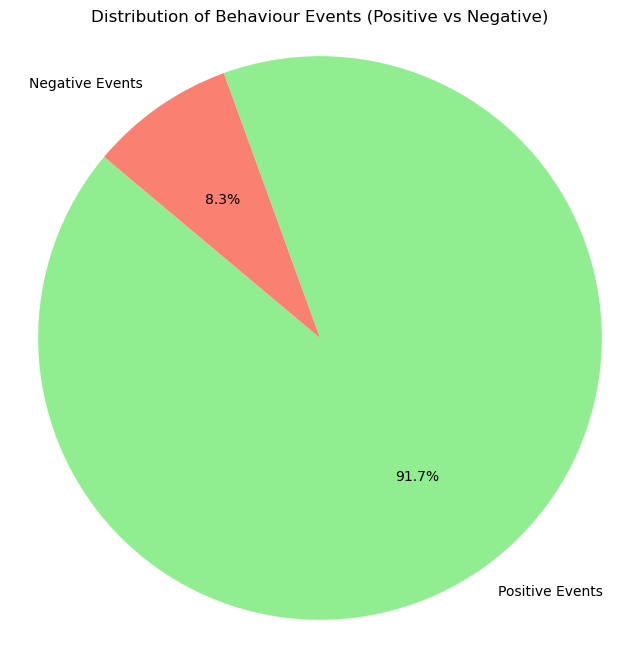

In [19]:
# Count positive and negative behaviour events
positive_count = behaviour_df[behaviour_df['CategoryName'] == 'Positive'].shape[0]
negative_count = behaviour_df[behaviour_df['CategoryName'] == 'Negative'].shape[0]

sizes = [positive_count, negative_count]
labels = ['Positive Events', 'Negative Events']

# Print the actual counts
print(f"Total Positive Events: {positive_count}")
print(f"Total Negative Events: {negative_count}")

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'salmon'])
plt.title('Distribution of Behaviour Events (Positive vs Negative)')
plt.axis('equal')

plt.show()

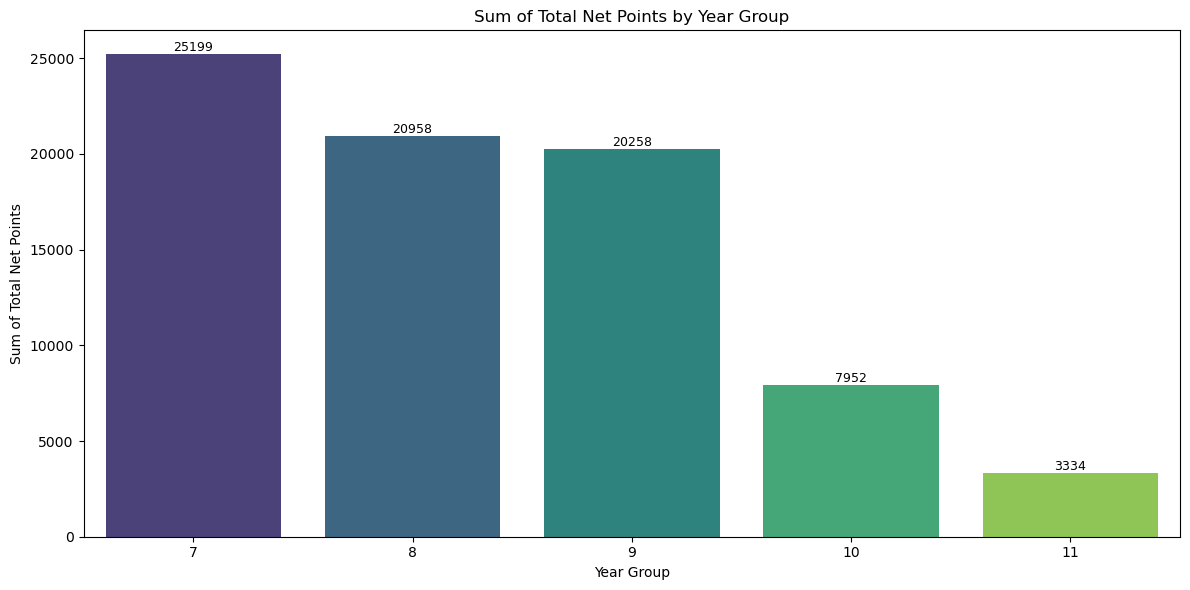

In [21]:
# Group by 'YearGroup' and sum the 'net_points'
net_points_by_year_group = dashboard.groupby('YearGroup')['net_points'].sum().reset_index()

# Sort by net points for better visualization
net_points_by_year_group = net_points_by_year_group.sort_values(by='net_points', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='YearGroup', y='net_points', data=net_points_by_year_group, palette='viridis')
plt.xlabel('Year Group')
plt.ylabel('Sum of Total Net Points')
plt.title('Sum of Total Net Points by Year Group')
plt.xticks(rotation=0)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [22]:
# Filter students with low attendance (attendance_pct < 85) and negative net_points
low_attendance_negative_behaviour_students = dashboard[
    (dashboard['attendance_pct'] < 85) &
    (dashboard['net_points'] < 0)
]

print("Students with Low Attendance and Negative Behaviour Points:")
print(low_attendance_negative_behaviour_students[['StudentID', 'First Name', 'Last Name', 'attendance_pct', 'net_points']])

Students with Low Attendance and Negative Behaviour Points:
     StudentID     First Name     Last Name  attendance_pct  net_points
3         9121   Firstname 13   Lastname 13       77.941176       -12.0
32       11010   Firstname 42   Lastname 42       82.352941       -10.0
39       11629   Firstname 51   Lastname 51       72.058824       -67.0
119      10192  Firstname 154  Lastname 154       64.705882       -42.0
174      10195  Firstname 210  Lastname 210       52.985075       -25.0
286      10120  Firstname 343  Lastname 343       82.089552      -117.0
293      10188  Firstname 350  Lastname 350       80.882353      -169.0
296      10488  Firstname 353  Lastname 353       61.194030      -194.0
412      11657  Firstname 500  Lastname 500       53.676471        -9.0
466       9198  Firstname 592  Lastname 592       83.823529       -19.0
487      10434  Firstname 622  Lastname 622       81.617647       -48.0
512      11655  Firstname 650  Lastname 650       83.088235       -13.0
524 

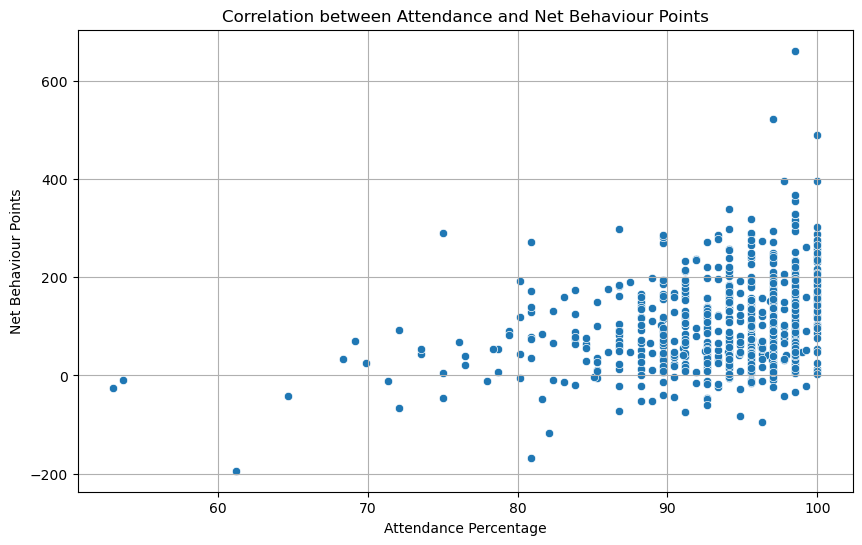

Correlation coefficient between Attendance Percentage and Net Behaviour Points: 0.29


In [23]:
# Plotting the correlation between attendance and behaviour
plt.figure(figsize=(10, 6))
sns.scatterplot(x='attendance_pct', y='net_points', data=dashboard)
plt.xlabel('Attendance Percentage')
plt.ylabel('Net Behaviour Points')
plt.title('Correlation between Attendance and Net Behaviour Points')
plt.grid(True)
plt.show()

# Calculate and print the correlation coefficient
correlation = dashboard['attendance_pct'].corr(dashboard['net_points'])
print(f"Correlation coefficient between Attendance Percentage and Net Behaviour Points: {correlation:.2f}")

In [24]:
# Create a target variable: 1 if low attendance (<85%) AND negative net points (<0), 0 otherwise
dashboard['Target'] = ((dashboard['attendance_pct'] < 85) & (dashboard['net_points'] < 0)).astype(int)

# Select features (X) and target (y)
# We'll use attendance_pct and net_points as features for this simple model
features = ['attendance_pct', 'net_points']
X = dashboard[features].copy()
y = dashboard['Target']

# Handle potential missing values in features (if any)
# A common approach is to fill with the mean, median, or 0
X = X.fillna(X.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify to maintain target distribution

# Scale the features (important for models like Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# To identify students with low attendance and negative net points using the model:
# Predict on the entire dataset or a new dataset
dashboard['Predicted_at_Risk'] = model.predict(scaler.transform(dashboard[features].fillna(dashboard[features].mean())))

# Filter students predicted to have low attendance and negative behaviour
predicted_at_risk_students = dashboard[dashboard['Predicted_at_Risk'] == 1]

print("\nStudents Predicted to have Low Attendance and Negative Behaviour Points:")
print(predicted_at_risk_students[['StudentID', 'First Name', 'Last Name', 'attendance_pct', 'net_points', 'Predicted_at_Risk']])

Model Evaluation:
[[145   1]
 [  0   3]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       146
           1       0.75      1.00      0.86         3

    accuracy                           0.99       149
   macro avg       0.88      1.00      0.93       149
weighted avg       0.99      0.99      0.99       149

Accuracy: 0.99

Students Predicted to have Low Attendance and Negative Behaviour Points:
     StudentID     First Name     Last Name  attendance_pct  net_points  \
39       11629   Firstname 51   Lastname 51       72.058824       -67.0   
119      10192  Firstname 154  Lastname 154       64.705882       -42.0   
174      10195  Firstname 210  Lastname 210       52.985075       -25.0   
286      10120  Firstname 343  Lastname 343       82.089552      -117.0   
293      10188  Firstname 350  Lastname 350       80.882353      -169.0   
296      10488  Firstname 353  Lastname 353       61.194030      -194.0   
338      13321  Fi

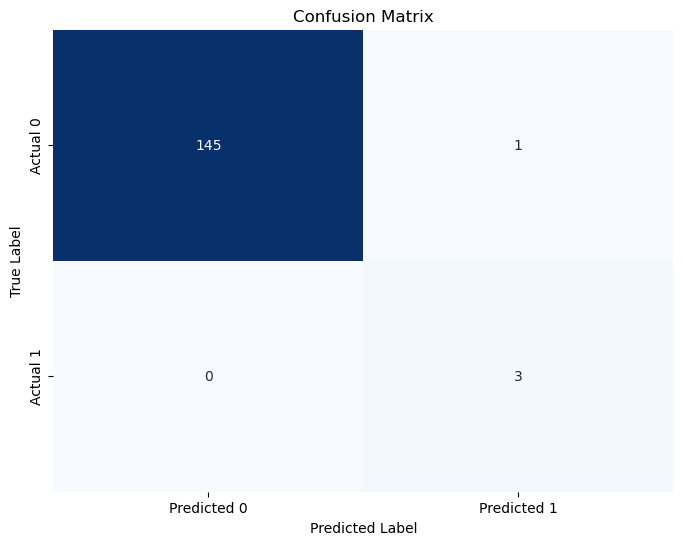

In [25]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

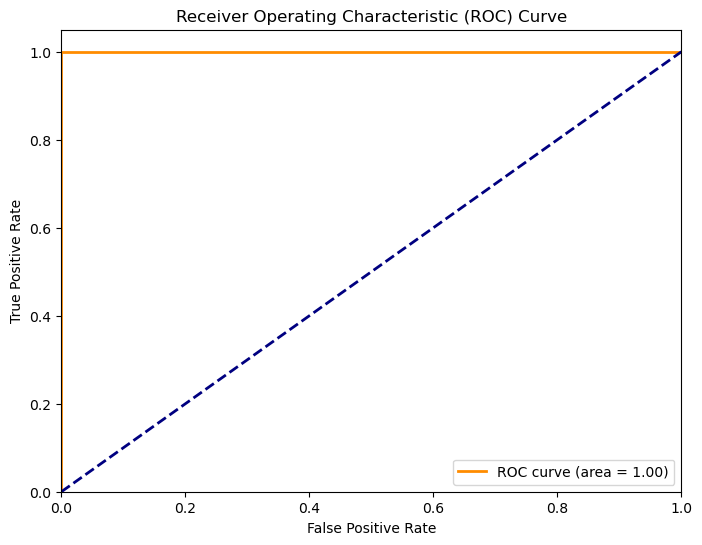

ROC AUC Score: 1.00


In [26]:
# Predict probabilities for the positive class (class 1)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

In [27]:
#  Merge in YearGroup and Gender from students_df into behaviour_df
if 'StudentID' not in behaviour_df.columns:
    raise KeyError("behaviour_df is missing the 'StudentID' column – cannot merge YearGroup.")

# Perform the merge
behaviour = behaviour_df.merge(
    students_df[['StudentID', 'YearGroup', 'Gender']],
    on='StudentID',
    how='left',
    validate='many_to_one'
)

# Let's explicitly drop columns that might have been introduced from the right dataframe if they conflict
# and rename the columns from the left dataframe if needed.
# Assuming students_df has the correct 'YearGroup' and 'Gender' columns
behaviour.rename(columns={'YearGroup_y': 'YearGroup', 'Gender_y': 'Gender'}, inplace=True)
# Now drop any potentially duplicate columns with '_x' suffix if they were in the original behaviour_df
behaviour.drop(columns=[col for col in behaviour.columns if col.endswith('_x')], errors='ignore', inplace=True)


# 3) Merge in 'School Week' from date_df, keyed on EventDate → Date
if 'EventDate' not in behaviour.columns or 'Date' not in date_df.columns:
    raise KeyError("Either 'EventDate' not in behaviour or 'Date' not in date_df – cannot merge School Week.")

behaviour = behaviour.merge(
    date_df[['Date', 'School Week']],
    left_on='EventDate',
    right_on='Date',
    how='left',
    validate='many_to_one'
)
# Drop the redundant 'Date' column from the merge
behaviour.drop(columns=['Date'], inplace=True)


# 4) Clean up YearGroup and School Week
# Convert to numeric, drop rows that fail
behaviour['YearGroup'] = pd.to_numeric(behaviour['YearGroup'], errors='coerce')
behaviour['School Week'] = pd.to_numeric(behaviour['School Week'], errors='coerce')

before_drop = len(behaviour)
behaviour_cleaned = behaviour.dropna(subset=['YearGroup', 'School Week']).copy()
after_drop = len(behaviour_cleaned)
print(f"Dropped {before_drop - after_drop} rows due to missing YearGroup or School Week.")

# Cast YearGroup to int
behaviour_cleaned['YearGroup'] = behaviour_cleaned['YearGroup'].astype(int)
behaviour_cleaned['School Week'] = behaviour_cleaned['School Week'].astype(int) # Also cast School Week to int

# 5) Pivot to create the heatmap data
if 'EventID' not in behaviour_cleaned.columns:
    # If you have another non-null column, use that instead
    pivot_value = behaviour_cleaned.columns[0]
    print(f"'EventID' not found – using '{pivot_value}' as the value column for counts.")
else:
    pivot_value = 'EventID'

behaviour_heatmap_data = behaviour_cleaned.pivot_table(
    index='YearGroup',
    columns='School Week',
    values=pivot_value,
    aggfunc='count',
).fillna(0).sort_index().sort_index(axis=1)

# 6) Draw the attendance trend & heatmap, save to disk

# Attendance trend (assumes you have average_attendance_by_year_week ready)
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='School Week',
    y='Average Attendance Percentage',
    hue='YearGroup',
    data=average_attendance_by_year_week,
    marker='o'
)
plt.ylim(0, 100)
plt.title('Average Attendance Percentage by Year Group and Week')
plt.savefig('attendance_trend.png')
plt.close()

# Behaviour heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    behaviour_heatmap_data,
    annot=True,
    fmt='g',
    cmap='YlOrRd',
    cbar_kws={'label': 'Incident Count'}
)
plt.title('Behaviour Incident Heatmap by Year Group and School Week')
plt.xlabel('School Week')
plt.ylabel('Year Group')
plt.savefig('behaviour_heatmap.png')
plt.close()

# 7) Build flagged-students summary and generate HTML
# Ensure dashboard DataFrame and 'Predicted_at_Risk' column are created from the previous code
if 'Predicted_at_Risk' not in dashboard.columns:
     # Re-run the classification model part if not already done
    print("Running classification model to create 'Predicted_at_Risk' column...")
    # Create a target variable: 1 if low attendance (<85%) AND negative net points (<0), 0 otherwise
    dashboard['Target'] = ((dashboard['attendance_pct'] < 85) & (dashboard['net_points'] < 0)).astype(int)

    # Select features (X) and target (y)
    features = ['attendance_pct', 'net_points']
    X = dashboard[features].copy()
    y = dashboard['Target']

    # Handle potential missing values in features
    X = X.fillna(X.mean())

    # Split data (optional, but good practice if retraining)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict on the entire dataset
    dashboard['Predicted_at_Risk'] = model.predict(scaler.transform(dashboard[features].fillna(dashboard[features].mean())))
    print("'Predicted_at_Risk' column created.")


flagged = dashboard[dashboard['Predicted_at_Risk'] == 1][
    ['StudentID','First Name','Last Name','attendance_pct','net_points']
].rename(columns={
    'attendance_pct':'Attendance %',
    'net_points':'Net Behaviour Points'
})

# A simple “risk score”
# Use .abs() for net points to treat both positive and negative points equally in the risk score magnitude
flagged['Risk Score'] = (100 - flagged['Attendance %']).abs() + flagged['Net Behaviour Points'].abs()
flagged = flagged.sort_values('Risk Score', ascending=False)

html = f"""
<!DOCTYPE html>
<html>
<head><title>Student Performance Report</title>
<style>
  body {{ font-family: Arial; margin: 20px; }}
  h1, h2 {{ color: #333; }}
  table {{ border-collapse: collapse; width: 80%; margin-top: 20px; }}
  th,td {{ border:1px solid #ddd; padding:8px; text-align: left; }}
  th {{ background:#f2f2f2; }}
  img {{ max-width:90%; margin:20px auto; display:block; }}
</style>
</head>
<body>
<h1>Student Performance Dashboard</h1>

<h2>Attendance Trends</h2>
<p>This chart shows the average attendance percentage for each year group across the academic weeks.</p>
<img src="attendance_trend.png" alt="Attendance Trend">

<h2>Behaviour Heatmap</h2>
<p>This heatmap visualizes the number of behaviour incidents for each year group per school week. Darker shades indicate a higher number of incidents.</p>
<img src="behaviour_heatmap.png" alt="Behaviour Heatmap">

<h2>Flagged Students</h2>
<p>Below is a summary of students identified as potentially at risk based on low attendance and negative behaviour points, along with a calculated risk score.</p>
{flagged.to_html(index=False)}

</body>
</html>
"""

with open('student_report.html','w') as f:
    f.write(html)

print("✅ Report and figures generated: ",
      ["student_report.html","attendance_trend.png","behaviour_heatmap.png"])



Dropped 1326 rows due to missing YearGroup or School Week.
✅ Report and figures generated:  ['student_report.html', 'attendance_trend.png', 'behaviour_heatmap.png']


In [29]:
display(FileLink('student_report.html', result_html_prefix="Click here to download: "))
display(FileLink('attendance_trend.png',   result_html_prefix="Click here to download: "))
display(FileLink('behaviour_heatmap.png',  result_html_prefix="Click here to download: "))

C:\Users\Admin\Desktop\MSc\The Project\Dissertation\student_report.html

C:\Users\Admin\Desktop\MSc\The Project\Dissertation\attendance_trend.png

C:\Users\Admin\Desktop\MSc\The Project\Dissertation\behaviour_heatmap.png